In [4]:
import tensorflow as tf
import pandas as pd
import pylab as pl
import statsmodels as sm
from statsmodels.regression import linear_model
from classify_name import *


%matplotlib notebook

In [3]:
LoadNetwork("goodModels/model_800units_0.005lr_20maxNameLen_10trainingfiles_192minibatch_35000iterations")

INFO:tensorflow:Restoring parameters from goodModels/model_800units_0.005lr_20maxNameLen_10trainingfiles_192minibatch_35000iterations


Comparison of diversities calculated using textmap and using the lstms
----------------


In [5]:
def castGiniDiv(castList,nameDict,ethDict,numName=True,lstm=False):

    cList=castList.split(',')
    if numName:
        foo=[]

        # Not all names are in the list! imdb has some missing names apparently
        for tmp in cList:
            try: foo.append(nameDict[tmp])
            except KeyError: pass

        cList=foo
        
    if not lstm:
        ethDist=pd.value_counts([ethdict[tmp] for tmp in cList]).values
    else:
        ethDist=pd.value_counts(ClassifyNames(cList)).values
    ethDist=ethDist/ethDist.sum()

    return 1-(ethDist**2).sum()




In [6]:
df=pd.read_csv('title.basics_processed.csv')
df=df[df.language=='en']

# Reading in principals
dp=pd.read_csv("title.principals.tsv",'\t')
tset=set(df.tconst)
dp=dp[dp.tconst.isin(tset)]

# Getting all cast members
casts=np.unique(','.join(dp.principalCast).split(','))
dn=pd.read_csv("name.basics.tsv",'\t')
dn=dn[dn.nconst.isin(set(casts))]
dndict=dict(dn[['nconst','primaryName']].values)

# Loading in ethnicities
ethdicttmp=pickle.load(open("imdbeths.pkl",'rb'))
ethdict={tmp[0]:','.join([tmp2['best'] for tmp2 in tmp[1]]) for tmp in ethdicttmp.items()}


In [7]:
# Finding Gini diversity
gini=lambda instr:castGiniDiv(instr,dndict,ethdict)
dp['gini']=dp.principalCast.apply(gini)

In [8]:
ginilstm=lambda instr:castGiniDiv(instr,dndict,ethdict,lstm=True)
dp['ginilstm']=dp.principalCast.apply(ginilstm)

In [9]:
dp['constant']=1
dp.head()

,tconst,principalCast,gini,ginilstm,constant
318613,tt0339736,"nm0792259,nm0000539,nm0113158,nm2999181,nm0462...",0.66,0.66,1
416238,tt0443533,"nm0023940,nm1842569,nm0383533,nm0001394,nm0586...",0.80,0.80,1
432921,tt0460890,"nm0000295,nm0238698,nm1989536,nm0074100,nm0633...",0.46,0.46,1
464736,tt0494276,"nm0081863,nm1905354,nm2091168,nm1906337,nm1900...",0.66,0.66,1
766802,tt0803096,"nm0308672,nm0746273,nm0419169,nm1568035,nm0004...",0.64,0.64,1


<IPython.core.display.Javascript object>


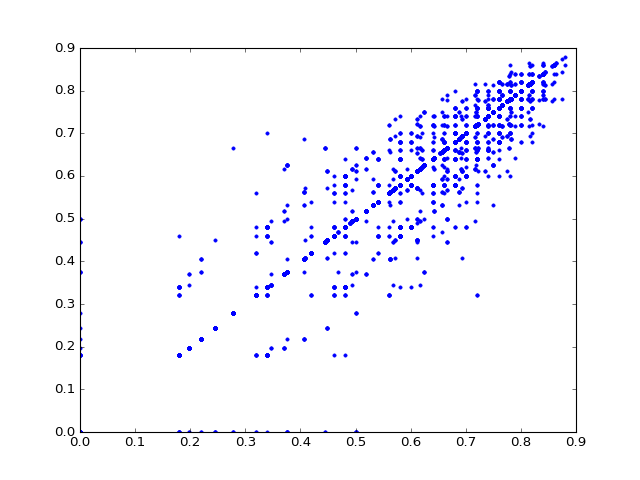

In [10]:
pl.plot(dp.gini,dp.ginilstm,'.')

In [11]:
linreg=linear_model.OLS(dp.gini,dp[['ginilstm','constant']])
result=linreg.fit()

In [12]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   gini   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                 1.821e+05
Date:                Wed, 06 Dec 2017   Prob (F-statistic):               0.00
Time:                        10:04:38   Log-Likelihood:                 11827.
No. Observations:                7541   AIC:                        -2.365e+04
Df Residuals:                    7539   BIC:                        -2.364e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ginilstm       0.9812      0.002    426.715      0.0